=== Avaliação do Modelo ===
Erro quadrático médio (MSE): 15122.74
Coeficiente de determinação (R²): 0.90
Coeficientes: [-112.45523865   28.04600187]
Intercepto: -407.9117415807432


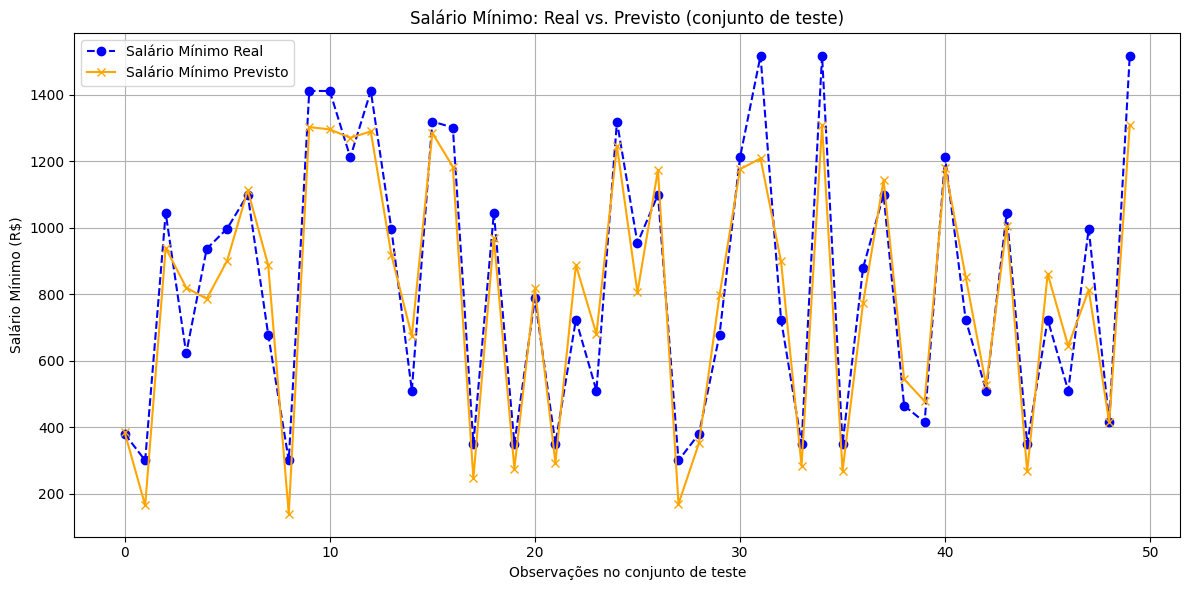

In [ ]:
# === Instalação das bibliotecas ===
!pip install matplotlib pandas scikit-learn plotly --quiet
# Instala silenciosamente as bibliotecas necessárias:
# matplotlib (gráficos estáticos), pandas (manipulação de dados),
# scikit-learn (modelagem e machine learning), plotly (gráficos interativos)

# === Importações ===
import pandas as pd                          # Biblioteca para manipulação de dados
import matplotlib.pyplot as plt              # Biblioteca para gráficos estáticos
import requests                              # Usada para fazer requisições HTTP à API do Banco Central
from sklearn.linear_model import LinearRegression         # Regressão Linear
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de avaliação do modelo
from sklearn.model_selection import train_test_split      # Separação em treino/teste
import plotly.graph_objects as go                         # Gráficos interativos

# === Função para buscar séries do SGS (Banco Central) ===
def buscar_serie_sgs(codigo, nome_coluna, data_inicio):
    # Monta a URL da API do SGS do Banco Central com o código da série, data inicial e final
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados?formato=json&dataInicial={data_inicio}&dataFinal=31/12/2025'

    # Faz a requisição dos dados
    response = requests.get(url)

    # Converte a resposta JSON para lista de dicionários
    data = response.json()

    # Transforma a lista em DataFrame
    df = pd.DataFrame(data)

    # Converte a coluna de data para datetime
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)

    # Converte a coluna de valor para float, trocando ',' por '.' e tratando erros
    df['valor'] = pd.to_numeric(df['valor'].str.replace(',', '.'), errors='coerce')

    # Renomeia colunas
    df.columns = ['Data', nome_coluna]

    return df  # Retorna o DataFrame com duas colunas: Data e o nome da série

# === Coleta dos dados ===
salario_minimo = buscar_serie_sgs(1619, 'Salario_Minimo', '01/01/1995')  # Série histórica do salário mínimo
ipca = buscar_serie_sgs(433, 'IPCA', '01/01/1995')                        # IPCA (inflação oficial)
endividamento = buscar_serie_sgs(19882, 'Endividamento', '01/01/1995')   # Endividamento das famílias

# === Previsão de Endividamento até 2025 ===
endividamento['Ano'] = endividamento['Data'].dt.year  # Cria coluna com o ano de cada registro

# Filtra apenas dados até 2021 (último ano com dados reais)
df_endiv_train = endividamento[endividamento['Ano'] <= 2021]

# Define variáveis preditoras e alvo para modelo de regressão
X_endiv = df_endiv_train[['Ano']]              # Ano como variável independente
y_endiv = df_endiv_train['Endividamento']      # Endividamento como variável dependente

# Cria e treina modelo de regressão linear
modelo_endiv = LinearRegression()
modelo_endiv.fit(X_endiv, y_endiv)

# Cria DataFrame com anos futuros (2022 a 2025) e prevê os valores de endividamento
anos_futuros = pd.DataFrame({'Ano': list(range(2022, 2026))})
anos_futuros['Endividamento'] = modelo_endiv.predict(anos_futuros)

# Constrói coluna de datas (1º de janeiro de cada ano previsto)
anos_futuros['Data'] = pd.to_datetime(anos_futuros['Ano'].astype(str) + '-01-01')

# Junta os dados históricos com os dados previstos
endividamento_previsto = pd.concat([endividamento[['Data', 'Endividamento']], anos_futuros[['Data', 'Endividamento']]])
endividamento_previsto.sort_values('Data', inplace=True)
endividamento_previsto.reset_index(drop=True, inplace=True)

# === Interpolação simples para tratar nulos ===
# Caso existam valores faltantes nas séries, a interpolação linear completa os dados
for df in [salario_minimo, ipca, endividamento_previsto]:
    df.interpolate(method='linear', inplace=True)

# === Unificação das bases ===
# Junta as três séries por data, usando junção externa (outer join) para não perder dados
df_final = pd.merge(salario_minimo, ipca, on='Data', how='outer')
df_final = pd.merge(df_final, endividamento_previsto, on='Data', how='outer')

# Ordena os dados pela data e trata valores ausentes novamente
df_final.sort_values('Data', inplace=True)
df_final.interpolate(method='linear', inplace=True)
df_final.dropna(inplace=True)  # Remove qualquer linha que ainda contenha valores nulos

# === Modelagem: Regressão Linear para prever Salário Mínimo com base em IPCA e Endividamento ===
df_modelo = df_final.copy()
df_modelo['Ano'] = df_modelo['Data'].dt.year  # Cria coluna "Ano" para análise adicional se necessário

# Define variáveis explicativas e variável alvo
X = df_modelo[['IPCA', 'Endividamento']]
y = df_modelo['Salario_Minimo']

# Divide os dados em treino (80%) e teste (20%) de forma aleatória mas reprodutível
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cria, treina e realiza a predição com modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)  # Erro quadrático médio
r2 = r2_score(y_test, y_pred)             # Coeficiente de determinação (0 a 1)

# Exibe os resultados do modelo
print("=== Avaliação do Modelo ===")
print(f"Erro quadrático médio (MSE): {mse:.2f}")
print(f"Coeficiente de determinação (R²): {r2:.2f}")
print(f"Coeficientes: {modelo.coef_}")         # Impacto de cada variável no salário mínimo
print(f"Intercepto: {modelo.intercept_}")      # Valor base do modelo

# === Dashboard interativo com Plotly ===
# Cria gráfico interativo com 3 linhas (Salário, IPCA e Endividamento)
fig = go.Figure()

# Salário mínimo
fig.add_trace(go.Scatter(x=df_final['Data'], y=df_final['Salario_Minimo'],
                         mode='lines', name='Salário Mínimo', line=dict(color='blue')))

# IPCA (multiplicado por 100 para escalar e visualizar melhor)
fig.add_trace(go.Scatter(x=df_final['Data'], y=df_final['IPCA']*100,
                         mode='lines', name='IPCA x100', line=dict(color='red', dash='dash')))

# Endividamento (multiplicado por 10 para escalar e visualizar melhor)
fig.add_trace(go.Scatter(x=df_final['Data'], y=df_final['Endividamento']*10,
                         mode='lines', name='Endividamento x10', line=dict(color='green')))

# Ajuste do layout do gráfico
fig.update_layout(title='Evolução dos Indicadores Econômicos',
                  xaxis_title='Ano',
                  yaxis_title='Valores',
                  template='plotly_white',
                  legend=dict(x=0.01, y=0.99))  # Legenda no canto superior esquerdo
fig.show()  # Exibe o gráfico

# === Exportando os arquivos ===
# Salva o DataFrame final em dois formatos: CSV e Excel
df_final.to_csv('Indicadores_Economicos.csv', index=False)
df_final.to_excel('Indicadores_Economicos.xlsx', index=False)


# === Comparação gráfica entre Real e Previsto (dados de teste) ===
# Este gráfico mostra como o modelo se saiu ao prever os valores do salário mínimo usando IPCA e Endividamento.
# Quanto mais próximas as duas linhas estiverem, melhor o desempenho do modelo.

plt.figure(figsize=(12, 6))  # Tamanho da figura
plt.plot(y_test.values, label='Salário Mínimo Real', marker='o', linestyle='--', color='blue')  # Linha dos valores reais
plt.plot(y_pred, label='Salário Mínimo Previsto', marker='x', linestyle='-', color='orange')    # Linha dos valores previstos
plt.title('Salário Mínimo: Real vs. Previsto (conjunto de teste)')  # Título do gráfico
plt.xlabel('Observações no conjunto de teste')                      # Rótulo do eixo X
plt.ylabel('Salário Mínimo (R$)')                                   # Rótulo do eixo Y
plt.legend()                                                        # Exibe a legenda
plt.grid(True)                                                      # Adiciona grade
plt.tight_layout()                                                  # Ajuste automático de layout
plt.show()                                                          # Exibe o gráfico